# SVRGModule Training with MNIST

This notebook creates a set of experiments training a multi-class logistic regression and a MLP on MNIST dataset. The experiment configurations are reproduced from paper _Accelerating Stochastic Gradient Descent using
Predictive Variance Reduction_ section 5. 

### Data Preprocessing
The MNIST images are gradscale, therefore the input shape is (batch_size, 1, 28, 28) where width and height of the source image is both 28. We will create a NDArrayIterator for iterating over the dataset and the dataset is normalized to range [0, 1] by dividing 255. 

In [4]:
import mxnet as mx
import logging
from mxnet.contrib.svrg_optimization.svrg_module import SVRGModule
import json

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# import for MNIST example
import os, errno
import gzip, struct
import numpy as np

In [6]:
batch_size = 64

In [7]:
def read_mnist_data(label, image):
    base_url = 'http://yann.lecun.com/exdb/mnist/'
    with gzip.open(download_file(base_url + label, os.path.join('data', label))) as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        label = np.fromstring(flbl.read(), dtype=np.int8)
    with gzip.open(download_file(base_url + image, os.path.join('data', image)), 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        image = np.fromstring(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
    return (label, image)

In [8]:
# Add for MNIST example
def download_file(url, local_fname=None, force_write=False):
    # requests is not default installed
    import requests
    if local_fname is None:
        local_fname = url.split('/')[-1]
    if not force_write and os.path.exists(local_fname):
        return local_fname

    dir_name = os.path.dirname(local_fname)

    if dir_name != "":
        if not os.path.exists(dir_name):
            try:  # try to create the directory if it doesn't exists
                os.makedirs(dir_name)
            except OSError as exc:
                if exc.errno != errno.EEXIST:
                    raise

    r = requests.get(url, stream=True)
    assert r.status_code == 200, "failed to open %s" % url
    with open(local_fname, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:  # filter out keep-alive new chunks
                f.write(chunk)
    return local_fname

In [9]:
def to4d(img):
    return img.reshape(img.shape[0], 1, 28, 28).astype(np.float32)/255

In [10]:
def create_mnist(batch_size=64):
    # read data
    (train_lbl, train_img) = read_mnist_data(
        'train-labels-idx1-ubyte.gz', 'train-images-idx3-ubyte.gz')
    (val_lbl, val_img) = read_mnist_data(
        't10k-labels-idx1-ubyte.gz', 't10k-images-idx3-ubyte.gz')
    train = mx.io.NDArrayIter(
        to4d(train_img), train_lbl, batch_size, shuffle=True)
    val = mx.io.NDArrayIter(
        to4d(val_img), val_lbl, batch_size)
    return (train, val)

### SVRGModule vs Module Intermediate Level API

We will create two modules, a SVRGModule with SVRG optimization logic under the hood and a standard Module with SGD optmization. 

In [22]:
def svrg_module_fit(train_iter, net, logging, output, num_epoch, metrics, optimizer_params=None):
    mod = SVRGModule(symbol=net, update_freq=2, logger=logging)
    mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
    mod.init_params(initializer=mx.init.Uniform(0.01), allow_missing=False, force_init=False, allow_extra=False)
    mod.init_optimizer(kvstore='local', optimizer='sgd', optimizer_params=optimizer_params)
    results = {}
    for e in range(num_epoch):
        results[e] = {}
        metrics.reset()
        if e % mod.update_freq == 0:
            mod.update_full_grads(train_iter)
        train_iter.reset()
        for batch in train_iter:
            mod.forward_backward(data_batch=batch)
            mod.update()
            mod.update_metric(metrics, batch.label)
        results[e]["cross-entropy"] = metrics.get()[1]
   
    f = open(output, 'w+')
    f.write(json.dumps(results, indent=4, sort_keys=True))
    f.close()
    

In [12]:
def module_sgd_fit(train_iter, net, logging, output, num_epoch, metrics, optimizer_params=None):
    mod = mx.mod. Module(symbol=net, logger=logging)
    mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
    mod.init_params(initializer=mx.init.Uniform(0.01), allow_missing=False, force_init=False, allow_extra=False)
    mod.init_optimizer(kvstore='local', optimizer='sgd', optimizer_params=optimizer_params)
    results = {}
    for e in range(num_epoch):
        results[e] = {}
        metrics.reset()
        train_iter.reset()
        for batch in train_iter:
            mod.forward_backward(data_batch=batch)
            mod.update()
            mod.update_metric(metrics, batch.label)
        results[e]["cross-entropy"] = metrics.get()[1]
   
    f = open(output, 'w+')
    f.write(json.dumps(results, indent=4, sort_keys=True))
    f.close()
    

### Multi-class Logistic Regression (Convex)

In [15]:
def create_convex_mnist(num_epoch):
    train_iter, val_iter = create_mnist()
    data = mx.sym.Variable("data")
    data = mx.sym.Flatten(data=data)
    fc1 = mx.sym.FullyConnected(data=data, num_hidden=10, name='fc1')
    net = mx.sym.SoftmaxOutput(data=fc1, name="softmax")
    
    logging.basicConfig(level=logging.INFO)
    # cross entropy loss
    metrics = mx.metric.CrossEntropy()

    #print("Fit a SVRGModule")
    #svrg_module_fit(train_iter, net, logging, "svrg_0.025.json", num_epoch, metrics)
    print("Fit a standard Module")
    module_sgd_fit(train_iter, net, logging, "sgd_0.001.json", num_epoch, metrics, optimizer_params={'learning_rate': 0.001})

In [16]:
create_convex_mnist(100)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  


Fit a standard Module


In [25]:
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

Text(0.5,0,'Epochs')

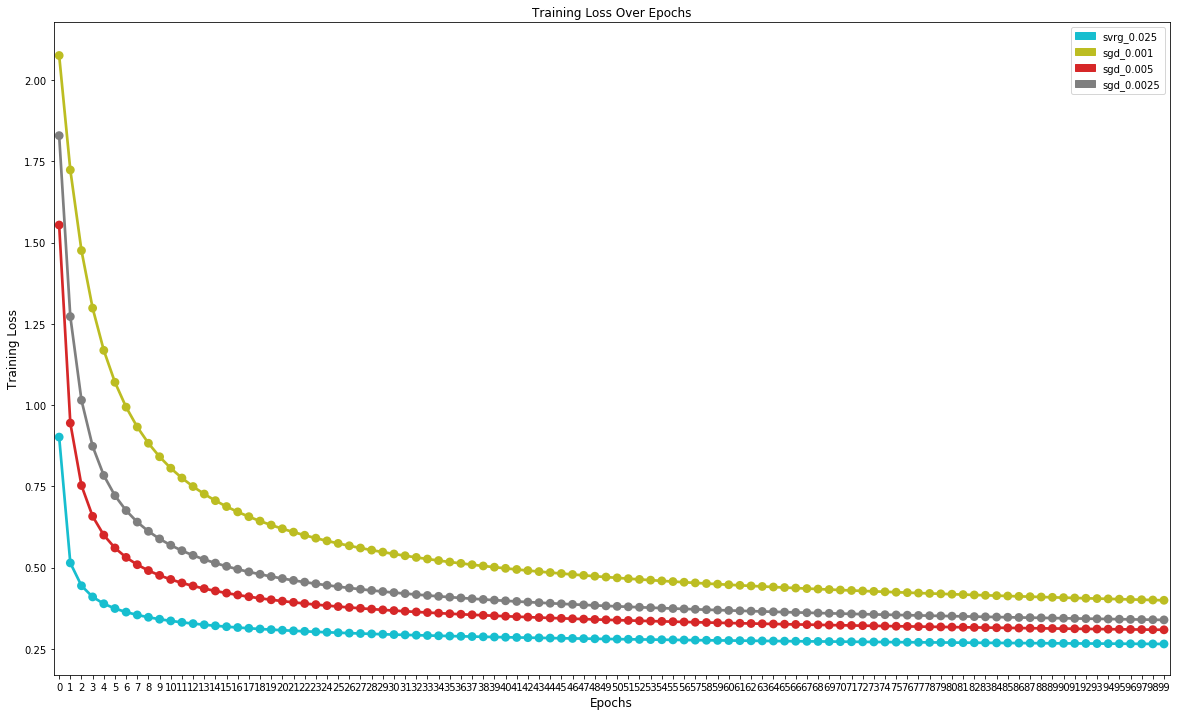

In [99]:
#Plot training loss over Epochs:
color = sns.color_palette()
#Draw Weight Variance Ratio
dataplot3 = {"svrg_loss": [], "sgd_loss": [], "sgd_loss2": [], "sgd_loss3": []}
with open('sgd_0.001.json') as sgd_data1, open('svrg_0.025.json') as svrg_data, open('sgd_0.005.json') as sgd_data2, open('sgd_0.0025.json') as sgd_data3:
    sgd_1 = json.load(sgd_data1)
    sgd_2 = json.load(sgd_data2)
    sgd_3 = json.load(sgd_data3)
    svrg = json.load(svrg_data)
    for epoch in range(100):
        dataplot3["svrg_loss"].append(svrg[str(epoch)]["cross-entropy"])
        dataplot3["sgd_loss"].append(sgd_1[str(epoch)]["cross-entropy"])
        dataplot3["sgd_loss2"].append(sgd_2[str(epoch)]["cross-entropy"])
        dataplot3["sgd_loss3"].append(sgd_3[str(epoch)]["cross-entropy"])
        

x3 = list(range(100))
plt.figure(figsize=(20, 12))
plt.title("Training Loss Over Epochs")
sns.pointplot(x3, dataplot3['svrg_loss'], color=color[9])
sns.pointplot(x3, dataplot3['sgd_loss'], color=color[8])
sns.pointplot(x3, dataplot3['sgd_loss2'], color=color[3])
sns.pointplot(x3, dataplot3['sgd_loss3'], color=color[7])
color_patch1 = mpatches.Patch(color=color[9], label="svrg_0.025")
color_patch2 = mpatches.Patch(color=color[8], label="sgd_0.001")
color_patch3 = mpatches.Patch(color=color[3], label="sgd_0.005")
color_patch4 = mpatches.Patch(color=color[7], label="sgd_0.0025")
plt.legend(handles=[color_patch1, color_patch2, color_patch3, color_patch4])
plt.ylabel('Training Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

### Non-Convex MLP

In the non-convex case, we will create a MLP with one fully connected hidden layer of 100 nodes and ten softmax output nodes. And we will use sigmoid activation function adn L2 regularization. 

In [20]:
def create_mnist_mlp(num_epoch):
    train_iter, val_iter = create_mnist(10)
    data = mx.sym.Variable('data')
    fc1 = mx.sym.FullyConnected(data=data, num_hidden=100, name="fc1")
    act1 = mx.sym.Activation(data=fc1, act_type="sigmoid")
    fc2 = mx.sym.FullyConnected(data=act1, num_hidden=10, name='fc2')
    net = mx.sym.SoftmaxOutput(data=fc2, name="softmax")    
    logging.basicConfig(level=logging.INFO)
    # Cross entropy loss 
    metrics = mx.metric.CrossEntropy()
    
    svrg_module_fit(train_iter, net, logging, "svrg_lr_scheduler.json", num_epoch, metrics, optimizer_params={'lr_scheduler': mx.lr_scheduler.FactorScheduler(step=10, factor=0.99)})
    #module_sgd_fit(train_iter, net, logging, "sgd_lr_scheduler.json", num_epoch, metrics, optimizer_params={'lr_scheduler': mx.lr_scheduler.FactorScheduler(step=10, factor=0.99)})

### Using lr_scheduler for module with SGD and SVRGModule with SVRG

In [23]:
create_mnist_mlp(10)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  """
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  
INFO:root:Update[11]: Change learning rate to 9.90000e-03
INFO:root:Update[21]: Change learning rate to 9.80100e-03
INFO:root:Update[31]: Change learning rate to 9.70299e-03
INFO:root:Update[41]: Change learning rate to 9.60596e-03
INFO:root:Update[51]: Change learning rate to 9.50990e-03
INFO:root:Update[61]: Change learning rate to 9.41480e-03
INFO:root:Update[71]: Change learning rate to 9.32065e-03
INFO:root:Update[81]: Change learning rate to 9.22745e-03
INFO:root:Update[91]: Change learning rate to 9.13517e-03
INFO:root:Update[101]: Change learning rate to 9.04382e-03
INFO:root:Upda

INFO:root:Update[1331]: Change learning rate to 2.62713e-03
INFO:root:Update[1341]: Change learning rate to 2.60085e-03
INFO:root:Update[1351]: Change learning rate to 2.57485e-03
INFO:root:Update[1361]: Change learning rate to 2.54910e-03
INFO:root:Update[1371]: Change learning rate to 2.52361e-03
INFO:root:Update[1381]: Change learning rate to 2.49837e-03
INFO:root:Update[1391]: Change learning rate to 2.47339e-03
INFO:root:Update[1401]: Change learning rate to 2.44865e-03
INFO:root:Update[1411]: Change learning rate to 2.42417e-03
INFO:root:Update[1421]: Change learning rate to 2.39992e-03
INFO:root:Update[1431]: Change learning rate to 2.37593e-03
INFO:root:Update[1441]: Change learning rate to 2.35217e-03
INFO:root:Update[1451]: Change learning rate to 2.32864e-03
INFO:root:Update[1461]: Change learning rate to 2.30536e-03
INFO:root:Update[1471]: Change learning rate to 2.28230e-03
INFO:root:Update[1481]: Change learning rate to 2.25948e-03
INFO:root:Update[1491]: Change learning 

INFO:root:Update[2701]: Change learning rate to 6.62983e-04
INFO:root:Update[2711]: Change learning rate to 6.56353e-04
INFO:root:Update[2721]: Change learning rate to 6.49790e-04
INFO:root:Update[2731]: Change learning rate to 6.43292e-04
INFO:root:Update[2741]: Change learning rate to 6.36859e-04
INFO:root:Update[2751]: Change learning rate to 6.30490e-04
INFO:root:Update[2761]: Change learning rate to 6.24186e-04
INFO:root:Update[2771]: Change learning rate to 6.17944e-04
INFO:root:Update[2781]: Change learning rate to 6.11764e-04
INFO:root:Update[2791]: Change learning rate to 6.05647e-04
INFO:root:Update[2801]: Change learning rate to 5.99590e-04
INFO:root:Update[2811]: Change learning rate to 5.93594e-04
INFO:root:Update[2821]: Change learning rate to 5.87658e-04
INFO:root:Update[2831]: Change learning rate to 5.81782e-04
INFO:root:Update[2841]: Change learning rate to 5.75964e-04
INFO:root:Update[2851]: Change learning rate to 5.70204e-04
INFO:root:Update[2861]: Change learning 

INFO:root:Update[4071]: Change learning rate to 1.67311e-04
INFO:root:Update[4081]: Change learning rate to 1.65638e-04
INFO:root:Update[4091]: Change learning rate to 1.63981e-04
INFO:root:Update[4101]: Change learning rate to 1.62342e-04
INFO:root:Update[4111]: Change learning rate to 1.60718e-04
INFO:root:Update[4121]: Change learning rate to 1.59111e-04
INFO:root:Update[4131]: Change learning rate to 1.57520e-04
INFO:root:Update[4141]: Change learning rate to 1.55945e-04
INFO:root:Update[4151]: Change learning rate to 1.54385e-04
INFO:root:Update[4161]: Change learning rate to 1.52841e-04
INFO:root:Update[4171]: Change learning rate to 1.51313e-04
INFO:root:Update[4181]: Change learning rate to 1.49800e-04
INFO:root:Update[4191]: Change learning rate to 1.48302e-04
INFO:root:Update[4201]: Change learning rate to 1.46819e-04
INFO:root:Update[4211]: Change learning rate to 1.45351e-04
INFO:root:Update[4221]: Change learning rate to 1.43897e-04
INFO:root:Update[4231]: Change learning 

INFO:root:Update[5441]: Change learning rate to 4.22227e-05
INFO:root:Update[5451]: Change learning rate to 4.18005e-05
INFO:root:Update[5461]: Change learning rate to 4.13825e-05
INFO:root:Update[5471]: Change learning rate to 4.09686e-05
INFO:root:Update[5481]: Change learning rate to 4.05589e-05
INFO:root:Update[5491]: Change learning rate to 4.01534e-05
INFO:root:Update[5501]: Change learning rate to 3.97518e-05
INFO:root:Update[5511]: Change learning rate to 3.93543e-05
INFO:root:Update[5521]: Change learning rate to 3.89608e-05
INFO:root:Update[5531]: Change learning rate to 3.85712e-05
INFO:root:Update[5541]: Change learning rate to 3.81854e-05
INFO:root:Update[5551]: Change learning rate to 3.78036e-05
INFO:root:Update[5561]: Change learning rate to 3.74256e-05
INFO:root:Update[5571]: Change learning rate to 3.70513e-05
INFO:root:Update[5581]: Change learning rate to 3.66808e-05
INFO:root:Update[5591]: Change learning rate to 3.63140e-05
INFO:root:Update[5601]: Change learning 

INFO:root:Update[6811]: Change learning rate to 1.06553e-05
INFO:root:Update[6821]: Change learning rate to 1.05488e-05
INFO:root:Update[6831]: Change learning rate to 1.04433e-05
INFO:root:Update[6841]: Change learning rate to 1.03389e-05
INFO:root:Update[6851]: Change learning rate to 1.02355e-05
INFO:root:Update[6861]: Change learning rate to 1.01331e-05
INFO:root:Update[6871]: Change learning rate to 1.00318e-05
INFO:root:Update[6881]: Change learning rate to 9.93148e-06
INFO:root:Update[6891]: Change learning rate to 9.83216e-06
INFO:root:Update[6901]: Change learning rate to 9.73384e-06
INFO:root:Update[6911]: Change learning rate to 9.63650e-06
INFO:root:Update[6921]: Change learning rate to 9.54014e-06
INFO:root:Update[6931]: Change learning rate to 9.44474e-06
INFO:root:Update[6941]: Change learning rate to 9.35029e-06
INFO:root:Update[6951]: Change learning rate to 9.25679e-06
INFO:root:Update[6961]: Change learning rate to 9.16422e-06
INFO:root:Update[6971]: Change learning 

INFO:root:Update[8181]: Change learning rate to 2.68899e-06
INFO:root:Update[8191]: Change learning rate to 2.66210e-06
INFO:root:Update[8201]: Change learning rate to 2.63548e-06
INFO:root:Update[8211]: Change learning rate to 2.60912e-06
INFO:root:Update[8221]: Change learning rate to 2.58303e-06
INFO:root:Update[8231]: Change learning rate to 2.55720e-06
INFO:root:Update[8241]: Change learning rate to 2.53163e-06
INFO:root:Update[8251]: Change learning rate to 2.50631e-06
INFO:root:Update[8261]: Change learning rate to 2.48125e-06
INFO:root:Update[8271]: Change learning rate to 2.45644e-06
INFO:root:Update[8281]: Change learning rate to 2.43187e-06
INFO:root:Update[8291]: Change learning rate to 2.40756e-06
INFO:root:Update[8301]: Change learning rate to 2.38348e-06
INFO:root:Update[8311]: Change learning rate to 2.35965e-06
INFO:root:Update[8321]: Change learning rate to 2.33605e-06
INFO:root:Update[8331]: Change learning rate to 2.31269e-06
INFO:root:Update[8341]: Change learning 

INFO:root:Update[9551]: Change learning rate to 6.78595e-07
INFO:root:Update[9561]: Change learning rate to 6.71809e-07
INFO:root:Update[9571]: Change learning rate to 6.65091e-07
INFO:root:Update[9581]: Change learning rate to 6.58440e-07
INFO:root:Update[9591]: Change learning rate to 6.51856e-07
INFO:root:Update[9601]: Change learning rate to 6.45337e-07
INFO:root:Update[9611]: Change learning rate to 6.38884e-07
INFO:root:Update[9621]: Change learning rate to 6.32495e-07
INFO:root:Update[9631]: Change learning rate to 6.26170e-07
INFO:root:Update[9641]: Change learning rate to 6.19909e-07
INFO:root:Update[9651]: Change learning rate to 6.13709e-07
INFO:root:Update[9661]: Change learning rate to 6.07572e-07
INFO:root:Update[9671]: Change learning rate to 6.01497e-07
INFO:root:Update[9681]: Change learning rate to 5.95482e-07
INFO:root:Update[9691]: Change learning rate to 5.89527e-07
INFO:root:Update[9701]: Change learning rate to 5.83632e-07
INFO:root:Update[9711]: Change learning 

INFO:root:Update[10911]: Change learning rate to 1.72981e-07
INFO:root:Update[10921]: Change learning rate to 1.71251e-07
INFO:root:Update[10931]: Change learning rate to 1.69538e-07
INFO:root:Update[10941]: Change learning rate to 1.67843e-07
INFO:root:Update[10951]: Change learning rate to 1.66164e-07
INFO:root:Update[10961]: Change learning rate to 1.64503e-07
INFO:root:Update[10971]: Change learning rate to 1.62858e-07
INFO:root:Update[10981]: Change learning rate to 1.61229e-07
INFO:root:Update[10991]: Change learning rate to 1.59617e-07
INFO:root:Update[11001]: Change learning rate to 1.58021e-07
INFO:root:Update[11011]: Change learning rate to 1.56441e-07
INFO:root:Update[11021]: Change learning rate to 1.54876e-07
INFO:root:Update[11031]: Change learning rate to 1.53327e-07
INFO:root:Update[11041]: Change learning rate to 1.51794e-07
INFO:root:Update[11051]: Change learning rate to 1.50276e-07
INFO:root:Update[11061]: Change learning rate to 1.48773e-07
INFO:root:Update[11071]:

INFO:root:Update[12261]: Change learning rate to 4.45398e-08
INFO:root:Update[12271]: Change learning rate to 4.40944e-08
INFO:root:Update[12281]: Change learning rate to 4.36535e-08
INFO:root:Update[12291]: Change learning rate to 4.32170e-08
INFO:root:Update[12301]: Change learning rate to 4.27848e-08
INFO:root:Update[12311]: Change learning rate to 4.23569e-08
INFO:root:Update[12321]: Change learning rate to 4.19334e-08
INFO:root:Update[12331]: Change learning rate to 4.15140e-08
INFO:root:Update[12341]: Change learning rate to 4.10989e-08
INFO:root:Update[12351]: Change learning rate to 4.06879e-08
INFO:root:Update[12361]: Change learning rate to 4.02810e-08
INFO:root:Update[12371]: Change learning rate to 3.98782e-08
INFO:root:Update[12381]: Change learning rate to 3.94794e-08
INFO:root:Update[12391]: Change learning rate to 3.90846e-08
INFO:root:Update[12401]: Change learning rate to 3.86938e-08
INFO:root:Update[12411]: Change learning rate to 3.83069e-08
INFO:root:Update[12421]:

INFO:root:Update[13611]: Change learning rate to 1.14683e-08
INFO:root:Update[13621]: Change learning rate to 1.13536e-08
INFO:root:Update[13631]: Change learning rate to 1.12401e-08
INFO:root:Update[13641]: Change learning rate to 1.11277e-08
INFO:root:Update[13651]: Change learning rate to 1.10164e-08
INFO:root:Update[13661]: Change learning rate to 1.09063e-08
INFO:root:Update[13671]: Change learning rate to 1.07972e-08
INFO:root:Update[13681]: Change learning rate to 1.06892e-08
INFO:root:Update[13691]: Change learning rate to 1.05823e-08
INFO:root:Update[13701]: Change learning rate to 1.04765e-08
INFO:root:Update[13711]: Change learning rate to 1.03717e-08
INFO:root:Update[13721]: Change learning rate to 1.02680e-08
INFO:root:Update[13731]: Change learning rate to 1.01653e-08
INFO:root:Update[13741]: Change learning rate to 1.00637e-08
INFO:root:Update[13751]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[13761]: now learning rate arrive

INFO:root:Update[14511]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14521]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14531]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14541]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14551]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14561]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14571]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14581]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14591]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14601]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[14611]: now l

INFO:root:Update[15361]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15371]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15381]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15391]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15401]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15411]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15421]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15431]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15441]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15451]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[15461]: now l

INFO:root:Update[16211]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16221]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16231]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16241]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16251]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16261]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16271]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16281]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16291]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16301]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[16311]: now l

INFO:root:Update[17061]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17071]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17081]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17091]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17101]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17111]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17121]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17131]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17141]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17151]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17161]: now l

INFO:root:Update[17911]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17921]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17931]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17941]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17951]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17961]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17971]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17981]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[17991]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18001]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18011]: now l

INFO:root:Update[18761]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18771]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18781]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18791]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18801]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18811]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18821]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18831]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18841]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18851]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[18861]: now l

INFO:root:Update[19611]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19621]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19631]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19641]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19651]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19661]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19671]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19681]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19691]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19701]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[19711]: now l

INFO:root:Update[20461]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20471]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20481]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20491]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20501]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20511]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20521]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20531]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20541]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20551]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[20561]: now l

INFO:root:Update[21311]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21321]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21331]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21341]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21351]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21361]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21371]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21381]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21391]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21401]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[21411]: now l

INFO:root:Update[22161]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22171]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22181]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22191]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22201]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22211]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22221]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22231]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22241]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22251]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[22261]: now l

INFO:root:Update[23011]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23021]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23031]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23041]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23051]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23061]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23071]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23081]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23091]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23101]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23111]: now l

INFO:root:Update[23861]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23871]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23881]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23891]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23901]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23911]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23921]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23931]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23941]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23951]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[23961]: now l

INFO:root:Update[24711]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24721]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24731]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24741]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24751]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24761]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24771]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24781]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24791]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24801]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[24811]: now l

INFO:root:Update[25561]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25571]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25581]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25591]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25601]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25611]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25621]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25631]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25641]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25651]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[25661]: now l

INFO:root:Update[26411]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26421]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26431]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26441]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26451]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26461]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26471]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26481]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26491]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26501]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[26511]: now l

INFO:root:Update[27261]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27271]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27281]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27291]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27301]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27311]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27321]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27331]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27341]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27351]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[27361]: now l

INFO:root:Update[28111]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28121]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28131]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28141]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28151]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28161]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28171]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28181]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28191]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28201]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28211]: now l

INFO:root:Update[28961]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28971]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28981]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[28991]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29001]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29011]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29021]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29031]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29041]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29051]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29061]: now l

INFO:root:Update[29811]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29821]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29831]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29841]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29851]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29861]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29871]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29881]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29891]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29901]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[29911]: now l

INFO:root:Update[30661]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30671]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30681]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30691]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30701]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30711]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30721]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30731]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30741]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30751]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[30761]: now l

INFO:root:Update[31511]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31521]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31531]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31541]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31551]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31561]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31571]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31581]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31591]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31601]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[31611]: now l

INFO:root:Update[32361]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32371]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32381]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32391]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32401]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32411]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32421]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32431]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32441]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32451]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[32461]: now l

INFO:root:Update[33211]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33221]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33231]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33241]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33251]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33261]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33271]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33281]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33291]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33301]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[33311]: now l

INFO:root:Update[34061]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34071]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34081]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34091]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34101]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34111]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34121]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34131]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34141]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34151]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34161]: now l

INFO:root:Update[34911]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34921]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34931]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34941]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34951]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34961]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34971]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34981]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[34991]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35001]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35011]: now l

INFO:root:Update[35761]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35771]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35781]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35791]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35801]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35811]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35821]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35831]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35841]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35851]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[35861]: now l

INFO:root:Update[36611]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36621]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36631]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36641]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36651]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36661]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36671]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36681]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36691]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36701]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[36711]: now l

INFO:root:Update[37461]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37471]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37481]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37491]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37501]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37511]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37521]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37531]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37541]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37551]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[37561]: now l

INFO:root:Update[38311]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38321]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38331]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38341]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38351]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38361]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38371]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38381]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38391]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38401]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[38411]: now l

INFO:root:Update[39161]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39171]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39181]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39191]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39201]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39211]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39221]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39231]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39241]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39251]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[39261]: now l

INFO:root:Update[40011]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40021]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40031]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40041]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40051]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40061]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40071]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40081]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40091]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40101]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40111]: now l

INFO:root:Update[40861]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40871]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40881]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40891]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40901]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40911]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40921]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40931]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40941]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40951]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[40961]: now l

INFO:root:Update[41711]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41721]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41731]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41741]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41751]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41761]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41771]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41781]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41791]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41801]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[41811]: now l

INFO:root:Update[42561]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42571]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42581]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42591]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42601]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42611]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42621]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42631]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42641]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42651]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[42661]: now l

INFO:root:Update[43411]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43421]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43431]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43441]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43451]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43461]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43471]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43481]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43491]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43501]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[43511]: now l

INFO:root:Update[44261]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44271]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44281]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44291]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44301]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44311]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44321]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44331]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44341]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44351]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[44361]: now l

INFO:root:Update[45111]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45121]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45131]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45141]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45151]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45161]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45171]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45181]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45191]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45201]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45211]: now l

INFO:root:Update[45961]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45971]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45981]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[45991]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46001]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46011]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46021]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46031]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46041]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46051]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46061]: now l

INFO:root:Update[46811]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46821]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46831]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46841]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46851]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46861]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46871]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46881]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46891]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46901]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[46911]: now l

INFO:root:Update[47661]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47671]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47681]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47691]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47701]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47711]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47721]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47731]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47741]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47751]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[47761]: now l

INFO:root:Update[48511]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48521]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48531]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48541]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48551]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48561]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48571]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48581]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48591]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48601]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[48611]: now l

INFO:root:Update[49361]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49371]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49381]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49391]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49401]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49411]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49421]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49431]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49441]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49451]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[49461]: now l

INFO:root:Update[50211]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50221]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50231]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50241]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50251]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50261]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50271]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50281]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50291]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50301]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[50311]: now l

INFO:root:Update[51061]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51071]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51081]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51091]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51101]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51111]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51121]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51131]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51141]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51151]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51161]: now l

INFO:root:Update[51911]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51921]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51931]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51941]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51951]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51961]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51971]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51981]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[51991]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52001]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52011]: now l

INFO:root:Update[52761]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52771]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52781]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52791]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52801]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52811]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52821]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52831]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52841]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52851]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[52861]: now l

INFO:root:Update[53611]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53621]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53631]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53641]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53651]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53661]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53671]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53681]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53691]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53701]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[53711]: now l

INFO:root:Update[54461]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54471]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54481]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54491]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54501]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54511]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54521]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54531]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54541]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54551]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[54561]: now l

INFO:root:Update[55311]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55321]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55331]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55341]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55351]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55361]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55371]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55381]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55391]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55401]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[55411]: now l

INFO:root:Update[56161]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56171]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56181]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56191]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56201]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56211]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56221]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56231]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56241]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56251]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[56261]: now l

INFO:root:Update[57011]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57021]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57031]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57041]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57051]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57061]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57071]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57081]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57091]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57101]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57111]: now l

INFO:root:Update[57861]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57871]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57881]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57891]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57901]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57911]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57921]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57931]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57941]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57951]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[57961]: now l

INFO:root:Update[58711]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58721]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58731]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58741]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58751]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58761]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58771]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58781]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58791]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58801]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[58811]: now l

INFO:root:Update[59561]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59571]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59581]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59591]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59601]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59611]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59621]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59631]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59641]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59651]: now learning rate arrived at 1.00000e-08, will not change in the future
INFO:root:Update[59661]: now l

Text(0.5,0,'Epochs')

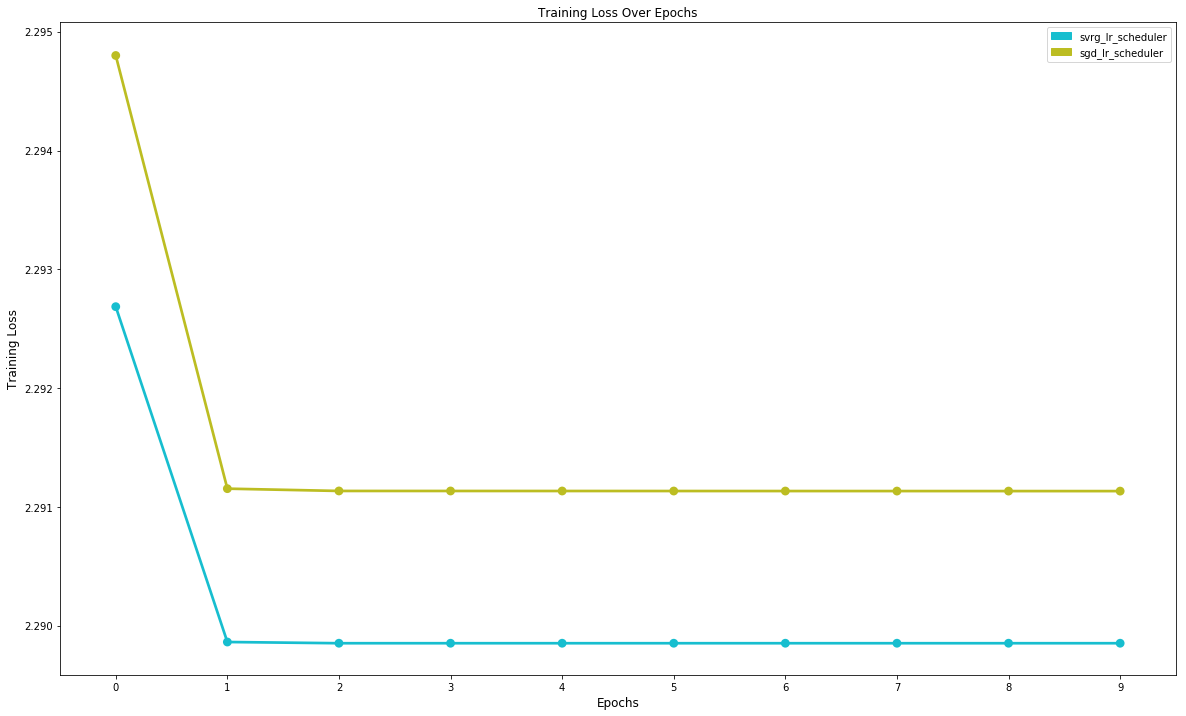

In [26]:
#Plot training loss over epochs
color = sns.color_palette()
#Draw Weight Variance Ratio
dataplot3 = {"svrg_loss": [], "sgd_loss": []}
with open('sgd_lr_scheduler.json') as sgd_data, open('svrg_lr_scheduler.json') as svrg_data:
    sgd = json.load(sgd_data)
    svrg = json.load(svrg_data)
    for epoch in range(10):
        dataplot3["svrg_loss"].append(svrg[str(epoch)]["cross-entropy"])
        dataplot3["sgd_loss"].append(sgd[str(epoch)]["cross-entropy"])
        
x3 = list(range(10))
plt.figure(figsize=(20, 12))
plt.title("Training Loss Over Epochs")
sns.pointplot(x3, dataplot3['svrg_loss'], color=color[9])
sns.pointplot(x3, dataplot3['sgd_loss'], color=color[8])
color_patch1 = mpatches.Patch(color=color[9], label="svrg_lr_scheduler")
color_patch2 = mpatches.Patch(color=color[8], label="sgd_lr_scheduler")
plt.legend(handles=[color_patch1, color_patch2])
plt.ylabel('Training Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)